In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from importlib import reload
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, ga, gc

In [2]:
second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Load in the filters from the model
with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
    filters = np.load(f)


In [3]:
# could do average of the filters instead of just picking the filter with the highest activation difference

# but taking the filter with the highest feature map weight makes sense as that filter would be most informative to prediction

### Find the filter with the largest activation

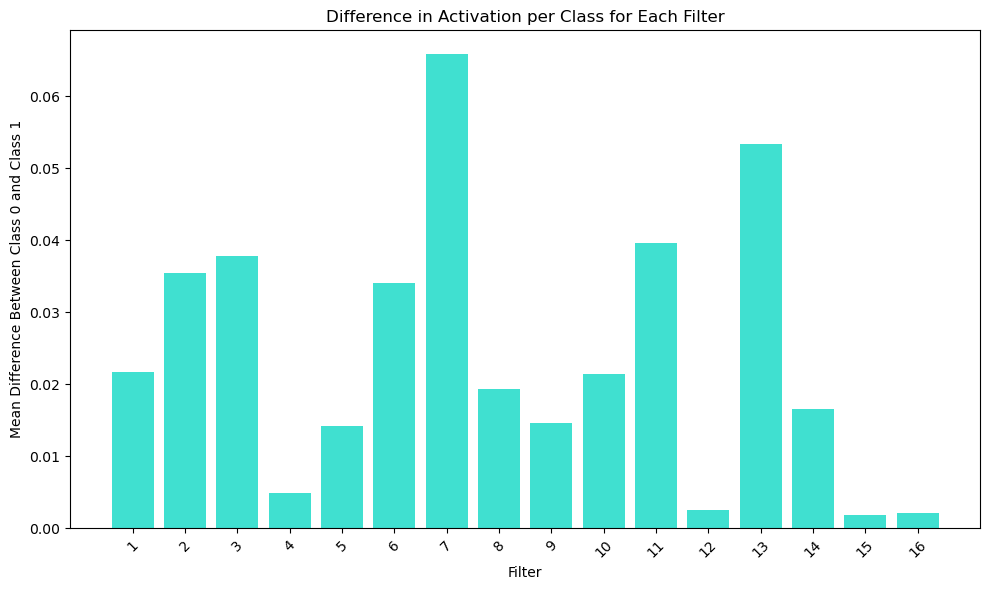

In [4]:
num_patients = 10

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, 
                                                     max_events=max_timesteps-1, 
                                                     max_nodes=max_event_codes)

replacement_true_lst, max_w_filt_lst, filt_nums = ga.get_act_metric_per_feat(model, num_filters, num_patients, 
                                                                             pat_df, max_event_codes, hip_or_knee,
                                                                             'max')
mean_activation_df = ga.act_diff(replacement_true_lst, max_w_filt_lst, filt_nums)

In [5]:
max_idx = mean_activation_df['Difference'].idxmax()
max_act_filt_num = mean_activation_df.loc[max_idx, 'Filter']

In [6]:
max_act_filt_num

7

In [7]:
filters_trans = tf.transpose(filters, [1,0]) # change filters to have one 2D array per filter rather than splitting the array 


filters_4d = []
for f in filters_trans:
    #print("Original flat filter:", f, "\n\n")
    
    filters_3d=[]
    #loop through one z/timestep at a time
    for i in range(filter_size):
        # Select numbers for the current tensor
        selected_numbers = f[i::filter_size]
        # Convert the selected numbers into a NumPy array and reshape it to a tensor
        oned_tensor = np.array(selected_numbers)#.reshape(-1, 1)
        #print("oned tensor", oned_tensor)
        tensor = oned_tensor.reshape(max_event_codes, max_event_codes)
        #print(tensor)
        filters_3d.append(np.array(tensor))
        
    filters_3d = np.array(filters_3d)
    filters_3d = filters_3d.reshape(max_event_codes,max_event_codes,filter_size)
    filters_4d.append(filters_3d)
        
    
# # Print the tensors
# for idx, filt in enumerate(filters_4d):
#     print(f"Filter {idx + 1}:")
#     print(filt)


filters_4d = np.array(filters_4d)    

In [8]:
filters_4d.shape

(16, 518, 518, 4)

In [9]:
max_act_filt = filters_4d[max_act_filt_num-1] # minus 1 as we don't have a filter called 0
max_act_filt

array([[[-7.23413154e-02, -2.86067836e-02, -8.99879187e-02,
          6.02342114e-02],
        [ 4.65595126e-02,  1.68466363e-02, -3.45661640e-02,
          4.82556559e-02],
        [-7.03618750e-02,  3.45764197e-02, -9.07245353e-02,
         -4.93861251e-02],
        ...,
        [-7.84013793e-02, -8.15542266e-02,  4.47446406e-02,
          3.15727293e-02],
        [-4.15739492e-02, -4.94063422e-02, -8.40492453e-03,
         -2.30617765e-02],
        [-1.90247018e-02, -4.79305759e-02,  5.19559719e-03,
         -6.26594108e-03]],

       [[ 1.54598821e-02,  1.74063705e-02, -5.12493066e-02,
         -4.50622961e-02],
        [-1.06660696e-02,  1.67864060e-03, -7.82011375e-02,
         -2.11267285e-02],
        [ 4.34111478e-03, -4.40985933e-02, -2.86462554e-03,
         -5.14322259e-02],
        ...,
        [-1.93276610e-02, -7.17730587e-03,  2.76116990e-02,
         -6.74507901e-05],
        [-9.80075542e-03, -1.52087416e-02,  2.80033331e-02,
         -4.93412800e-02],
        [-4.237

In [10]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)

dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0)



In [11]:
dense_tensor

<tf.Tensor: shape=(100, 518, 518), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

In [12]:
# dense_tensor[0:filter_size,:,:]

In [13]:
# Get the filter * each timestep average for each window pass
f = tf.transpose(max_act_filt, perm=[2, 1, 0]) # reorder filter

# NOTE: This assumes stride = 1
# First sort the middle of the pat graph which has all the filter timesteps passing over
tensors = []
for t in range(filter_size):
    graph_ends = max_timesteps-2*(filter_size-1)
    f_repeat = tf.repeat(tf.expand_dims(f[t,:,:], axis=0), repeats=graph_ends, axis=0) # times by two for both ends
    mid_graph = f_repeat * dense_tensor[filter_size-1:max_timesteps-filter_size+1, :, :]
    tensors.append(mid_graph)

stacked_tensors = tf.stack(tensors, axis=0)
mean_tensor_mid = tf.reduce_mean(stacked_tensors, axis=0)   


In [14]:
# sort out the parts of the graph where they don't have the full filter pass over them
# BEGINNING FIRST
num_to_append = filter_size - 1

# Generate slices_indices dynamically
slices_indices = []
for i in range(num_to_append):
    indices = list(range(min(f.shape[0], num_to_append - i)))
    indices.append(filter_size - 2 - i)  # Add the corresponding index for patient graph
    slices_indices.append(indices)

# calculate the means
for indices in slices_indices:
    # Perform element-wise multiplication and compute the mean
    multiplied_slices = [f[i, :, :] * dense_tensor[indices[-1], :, :] for i in indices[:-1]]
    mean_value = tf.reduce_mean(multiplied_slices, axis=0)
    mean_tensor_mid = tf.concat([tf.expand_dims(mean_value, axis=0), mean_tensor_mid], axis=0)

In [15]:
# END NEXT
base_list = list(range(1, filter_size))
negative_numbers = [-i for i in range(len(base_list), 0, -1)]

slices_indices = []
for i in range(len(base_list)):
    sublist = base_list[i:] + [negative_numbers[i]]
    slices_indices.append(sublist)

# calculate the means
for indices in slices_indices:
    # Perform element-wise multiplication and compute the mean
    multiplied_slices = [f[i, :, :] * dense_tensor[indices[-1], :, :] for i in indices[:-1]]
    mean_value = tf.reduce_mean(multiplied_slices, axis=0)
    # Add the tensor to the end of the mid tensor
    mean_tensor_mid = tf.concat([mean_tensor_mid, tf.expand_dims(mean_value, axis=0)], axis=0)

In [23]:
# this is the element-wise multiplication between the slices of the filter and the patient graph
# with the mean for each group of operations
# The values in this tensor should be used for the edge weightings
mean_tensor_mid

def create_edges_df_ga(patient_graph:np.array, edge_w_graph:tf.Tensor) -> pd.DataFrame:
    """Create a DataFrame of the edges of the patient graph, including the start and end nodes, the time 
    between visits, and the edge weight. For edge activation model.

    Args:
        patient_graph (np.array): 3D numpy array showing the patients health codes over time.
        edge_w_graph (tf.Tensor): 

    Returns:
        DataFrame: with columns start_node, end_node, time_between.
    """

    # Get the indices of non-zero elements
    patient_graph = np.round(patient_graph.numpy(), 4)
    edge_w_graph = np.array(edge_w_graph)
    t_indices, i_indices, j_indices = np.nonzero(patient_graph)
    non_zero_values = []
    edge_weights = []
    for t, i, j in zip(t_indices, i_indices, j_indices):
        non_zero_values.append(patient_graph[t, i, j])
        edge_weights.append(np.maximum(0, edge_w_graph[t, i, j])) # maximum compares 0 to value and gives a ReLU return
    #print("Non-zero values", non_zero_values)
    if not non_zero_values:
        print("Error: Graph does not contain any values.")

    # Calculate start_node_v and end_node_v
    start_node_v = np.where(t_indices == 0, 0, t_indices)
    end_node_v = start_node_v + 1

    edges_df = pd.DataFrame({
        'start_node': [f'{i}_v{start_v}' for i, start_v in zip(i_indices, start_node_v)],
        'end_node': [f'{j}_v{end_v}' for j, end_v in zip(j_indices, end_node_v)],
        'time_between': non_zero_values,
        'edge_weights': edge_weights
    })
    
    return edges_df

edges_df = create_edges_df_ga(dense_tensor, mean_tensor_mid) 
edges_df

,start_node,end_node,time_between,edge_weights
0,303_v0,464_v1,0.4627,0.038411
1,464_v1,401_v2,0.6477,0.000000
2,401_v2,189_v3,0.4643,0.000000
3,189_v3,517_v4,0.0315,0.000203
4,517_v4,366_v5,0.5475,0.000000
...,...,...,...,...
60,298_v60,381_v61,0.6555,0.001107
61,381_v61,437_v62,0.3275,0.006247
62,437_v62,296_v63,0.4431,0.000000
63,296_v63,509_v64,0.9392,0.037850


In [24]:
reload(ga)

<module 'src.ga' from 'c:\\Users\\alexg\\OneDrive - University of Leeds\\explainable_TGCNN\\src\\ga.py'>

In [25]:
# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

#l_map = gc.calc_local_map(model, grads, only_pos=False, filt_num=None)

#timestep_ave_grad_df = gc.calc_timestep_weights(stride, filter_size, l_map, max_timesteps)


read_code_pos_df = ga.map_read_code_labels(pos_df, read_code_map_df)

edge_pos_df = ga.create_edge_pos_df(edges_df, pos_df)

In [26]:
edge_pos_df

,start_node,end_node,time_between,edge_weights,x0,y0,node_num_x,x1,y1,node_num_y,edge_weight_perc
0,303_v0,464_v1,0.4627,0.038411,0,0,303,1,0,464,9.777314
1,464_v1,401_v2,0.6477,0.000000,1,0,464,2,0,401,0.000000
2,401_v2,189_v3,0.4643,0.000000,2,0,401,3,0,189,0.000000
3,189_v3,517_v4,0.0315,0.000203,3,0,189,4,0,517,0.051651
4,517_v4,366_v5,0.5475,0.000000,4,0,517,5,0,366,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
60,298_v60,381_v61,0.6555,0.001107,60,0,298,61,0,381,0.281881
61,381_v61,437_v62,0.3275,0.006247,61,0,381,62,0,437,1.590167
62,437_v62,296_v63,0.4431,0.000000,62,0,437,63,0,296,0.000000
63,296_v63,509_v64,0.9392,0.037850,63,0,296,64,0,509,9.634365
